In [22]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.python.data.ops.dataset_ops import PrefetchDataset

### 1. Найти данные для кластеризации. Данные в группе не должны повторяться!
### Внимание, если признаки в данных имеют очень сильно разные масштабы, то необходимо данные предварительно нормализовать.

In [23]:
# dataset, metadata = tfds.load('eurosat', as_supervised=True, with_info=True)
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
dataset: PrefetchDataset = dataset['train']
dataset = dataset.take(5000) # svm работает оч неторопливо (время квадратично от размера)

In [24]:
import tensorflow as tf
def convert_img_to_grayscale(image) -> list:
    return tfds.as_numpy(tf.image.rgb_to_grayscale(image)).ravel().tolist()

# class_names = [
#     'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
#     'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
class_names = [
    'Футболка / топ', "Шорты", "Свитер", "Платье",
    "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
    "Ботинок"]
# data_reshaped = pd.DataFrame([convert_img_to_grayscale(image) for image, label in dataset])
# target_names = pd.Series([class_names[label] for image, label in tfds.as_numpy(dataset)])

In [25]:
data_reshaped = pd.DataFrame([image.ravel().tolist() for image, label in tfds.as_numpy(dataset)])
target_names = pd.Series([class_names[label] for image, label in tfds.as_numpy(dataset)])

In [26]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
data_reshaped = pd.DataFrame(scaler.fit_transform(data_reshaped), columns=data_reshaped.columns)
data_reshaped.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07563,...,0.000000,0.000000,0.000000,0.432653,0.184314,0.270588,0.09465,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.564516,0.618474,0.023529,0.000000,0.192157,0.145098,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.036290,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0


### 2. Провести кластеризацию данных с помощью алгоритма k-means.
### Использовать «правило локтя» и коэффициент силуэта для поиска оптимального количества кластеров.

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

models = []
score1 = []
score2 = []
for i in range(2, len(class_names)*2):
    means_model =  KMeans(n_clusters=i, random_state=123, init='k-means++')
    means_model.fit(data_reshaped)
    models.append(means_model)
    score1.append(means_model.inertia_)
    score2.append(silhouette_score(data_reshaped, means_model.labels_))

In [28]:
len(class_names)

10

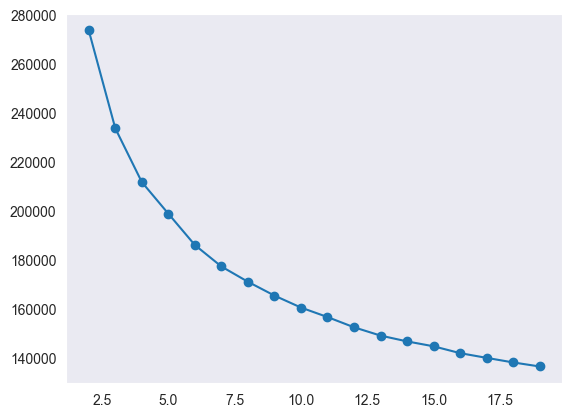

In [29]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(np.arange(2, len(class_names)*2), score1, marker='o')


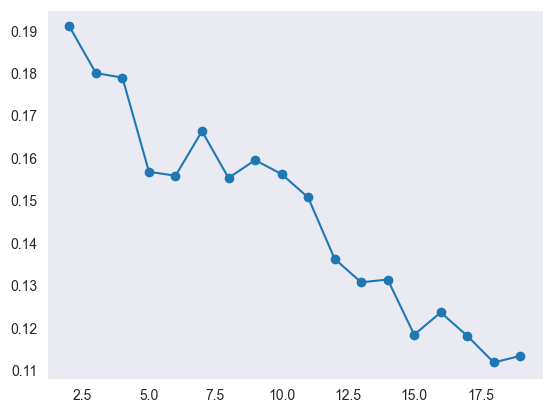

In [30]:
plt.grid()
plt.plot(np.arange(2, len(class_names)*2), score2, marker='o')

### 3. Провести кластеризацию данных с помощью алгоритма иерархической кластеризации.

In [33]:
from sklearn.cluster import AgglomerativeClustering
model2 = AgglomerativeClustering(6, compute_distances=True)
clastering = model2.fit(data_reshaped)

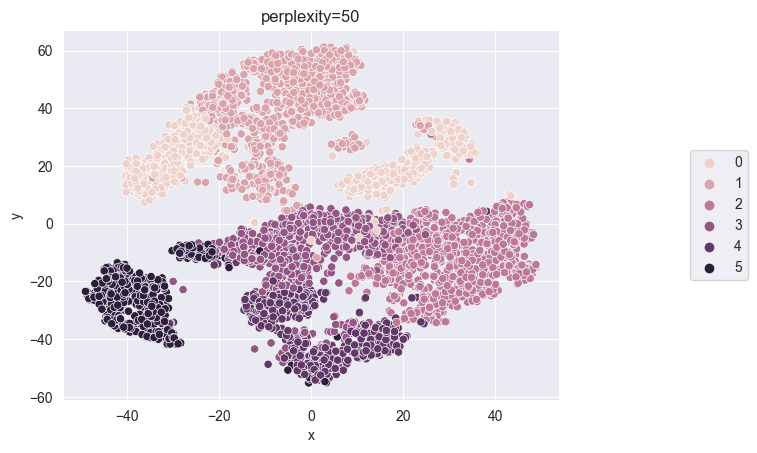

In [34]:
from sklearn.manifold import TSNE
import seaborn as sns

def t_sne_preproc(perp: int):
    tsne = TSNE(init='random', n_components=2, perplexity=perp, random_state=123, learning_rate='auto')
    tsne_features = tsne.fit_transform(data_reshaped)
    return tsne_features


def draw_plot(perp: int):
    tsne_features = t_sne_preproc(perp)
    plt_data = data_reshaped.copy()
    plt_data['x'] = tsne_features[:, 0]
    plt_data['y'] = tsne_features[:, 1]
    fig, ax = plt.subplots()
    ax.set_title(f'perplexity={perp}')
    g = sns.scatterplot(x='x', y='y', hue=clastering.labels_, data=plt_data)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

draw_plot(50)

### 4. Провести кластеризацию данных с помощью алгоритма DBSCAN.

### 5. Сравнить скорость работы алгоритмов. Результаты изобразить в виде таблицы.

### 6. Визуализировать кластеризованные данные с помощью t-SNE или UMAP если данные многомерные.
### Если данные трехмерные, то можно использовать трехмерный точечный график.